## Example of Principal Component Analysis with the waveforms

This example builds on top of the previous tutorial.

In [1]:
import requests
import zipfile
import os
from matplotlib import pyplot as plt
import numpy as np

import mne
from mne.channels import make_standard_montage
from mne.io import read_raw_cnt

import pandas as pd
from matplotlib import ticker
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from betaburst.detection.burst_detection import TfBursts 

#### This step is similar to what we have performed previously but now on all the channels. We won't download again the data

## Download data from the Zhou dataset
[1] Zhou B, Wu X, Lv Z, Zhang L, Guo X (2016) A Fully Automated Trial Selection Method for Optimization of Motor Imagery Based Brain-Computer Interface. PLoS ONE 11(9). https://doi.org/10.1371/journal.pone.0162657

In [2]:
data_path = "https://ndownloader.figshare.com/files/3662952"

zip_file_path = "zhou_data.zip"
extract_folder = "zhou_data"

# Download the compressed archive
response = requests.get(data_path)
with open(zip_file_path, 'wb') as file:
    file.write(response.content)

# Decompress the archive in extract folder
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
os.remove(zip_file_path)

print(f"File downloaded and extracted to {extract_folder}")

File downloaded and extracted to zhou_data


### Read data and extract epochs using [MNE](https://mne.tools/dev/) toolbox
We will load data only from a single subject and a single session.

In [3]:
subject = 2
session = '1A'
fname = f".\\zhou_data\\data\\S{subject}_{session}.cnt"
raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
stim = raw.annotations.description.astype(np.dtype("<10U"))
stim[stim == "1"] = "left_hand"
stim[stim == "2"] = "right_hand"
stim[stim == "3"] = "feet"
raw.annotations.description = stim
raw.set_montage(make_standard_montage("standard_1005"))
fs = raw.info['sfreq']

Reading 0 ... 227539  =      0.000 ...   910.156 secs...


C:\Users\ludov\AppData\Local\Temp\ipykernel_5976\2373179691.py:4: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


#### Notch filtering to remove line noise artifacts

In [4]:
raw.notch_filter(freqs=[50])
raw.filter(h_freq=120)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



<RawCNT | S2_1A.cnt, 16 x 227540 (910.2 s), ~27.8 MB, data loaded>

#### Create epochs

In [5]:
event_id = {'left_hand': 1, 'right_hand': 2}

# Keep only left/right hand motor imagery trials
events, _ = mne.events_from_annotations(raw, event_id=event_id)

# Create the epochs object
# Baseline period: -1.0 - 0.0s
# Task period: 0.0 - 5.0s
# Post-task period 5.0 - 7.0s
tmin, tmax = -1, 7 
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    baseline=(-1, 0), preload=True)

epochs.pick_channels(['C3', 'C4'])
print(epochs)

Used Annotations descriptions: ['left_hand', 'right_hand']
Not setting metadata
50 matching events found
Setting baseline interval to [0.5, 4.5] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 50 events and 1001 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
<Epochs |  50 events (all good), 0.5 – 4.5 s, baseline 0.5 – 4.5 s, ~796 kB, data loaded,
 'left_hand': 25
 'right_hand': 25>


In [6]:
times = epochs.times
trials = epochs.get_data(copy=True)[:, :, :-1]
fs = epochs.info['sfreq']

In [7]:
max_freq = 43
freqs = np.linspace(1, max_freq, 50)
search_range = np.where((freqs >= 10) & (freqs <= 33))[0]
upto_gamma_band = np.array([8, 40])
upto_gamma_range = np.where(
    np.logical_and(freqs >= upto_gamma_band[0], freqs <= upto_gamma_band[1])
)[0]

bm = TfBursts(
        fs,
        freqs = freqs,
        fr_band = upto_gamma_band,
        band_search_range = upto_gamma_range,
        band_limits=[8, 13, 30],
        remove_fooof=False,
    )

bursts_all_results = bm.burst_extraction(
    epochs=trials, band="beta", std_noise=4, regress_ERF=False
)

Extracting time frequency decomposition...
Initiating beta band burst extraction without aperiodic activity subtraction...
	Burst extraction for all channels: from 13 to 30 Hz.


KeyError: 'waveform_time'

Here we will combine burst features into a single data frame, and waveforms into a separate array. The first dimensions of the data frame and array are same, so boolean array based on e.g. "sensor" column can be used on the waveform array.

#### The PC scores can be analysed in many ways. Simple example here illustrates the principles of selecting the waveforms based on the dataframe. See the paper (https://doi.org/10.1016/j.pneurobio.2023.102490) for different ways the PC score was employed.

Here each burst PC score will be divided into quartiles and based on this selection, the average waveform from each quintile is going to be plotted.

Concatenating bursts along the different channels...


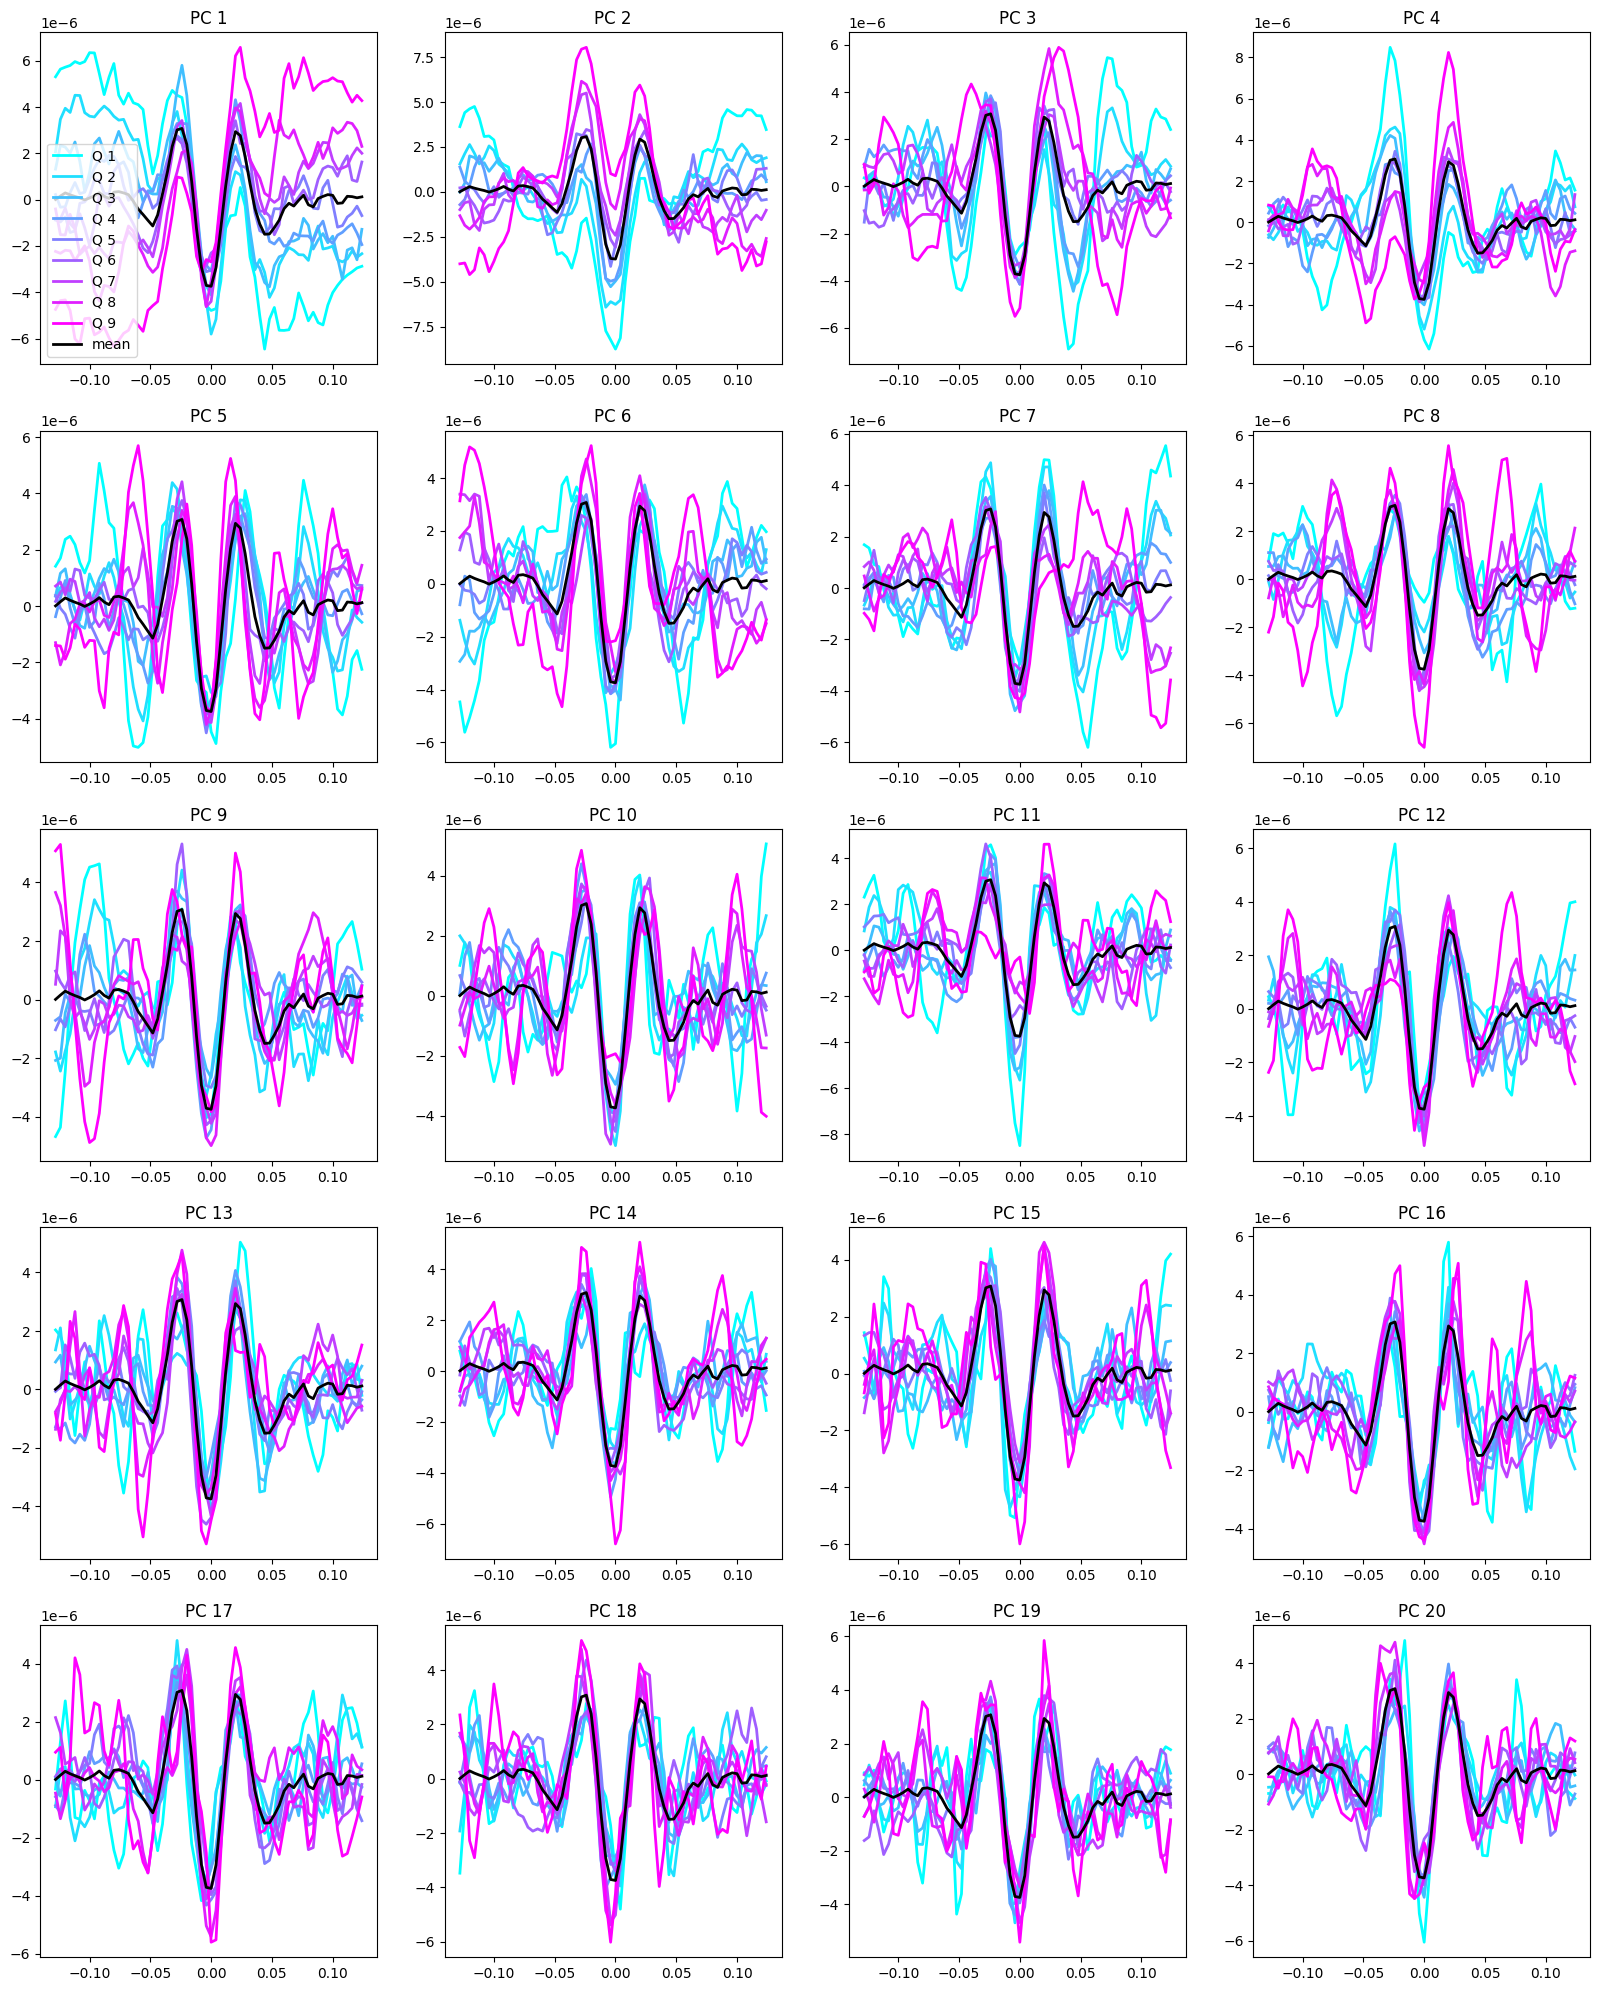

In [11]:
from betaburst.analysis.burst_analysis import BurstSpace

bs = BurstSpace(perc=0.5, nb_quartiles=10, tmin = 0, tmax = 5, time_step = 0.2)
scores_dists = bs.fit_transform(bursts_all_results)
bs.plot_waveforms()

We can also plot heatmaps corresponding to the burst rates of each quartile and PC during time

c:\Users\ludov\.conda\envs\embed\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ludov\.conda\envs\embed\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


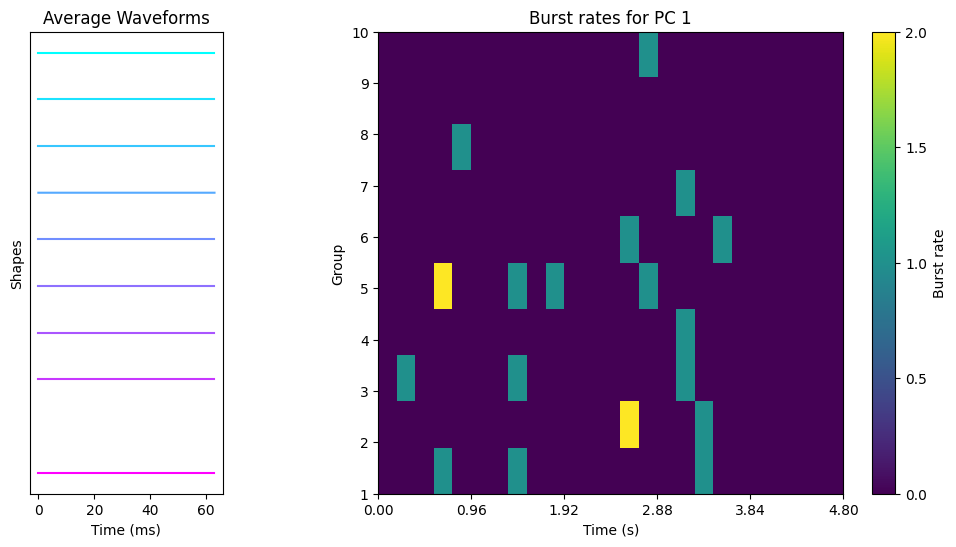

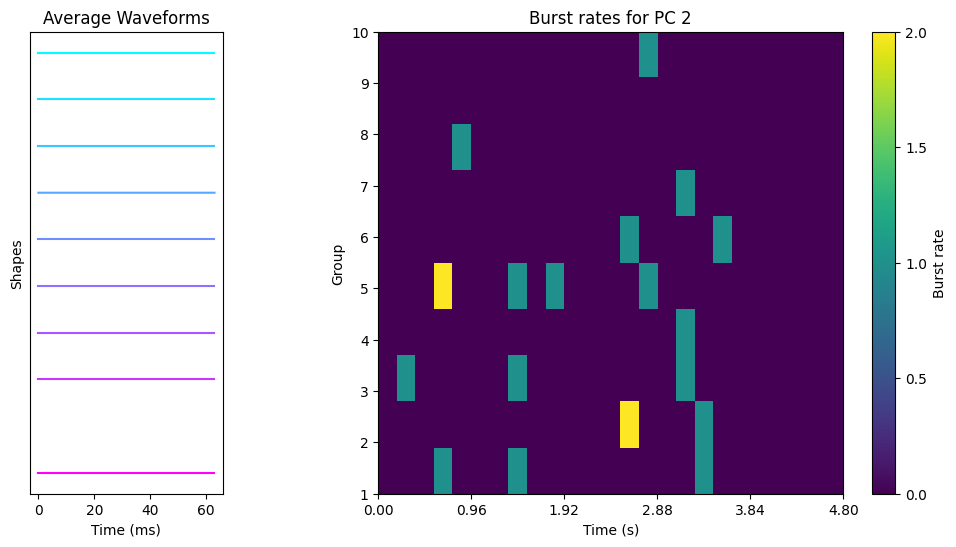

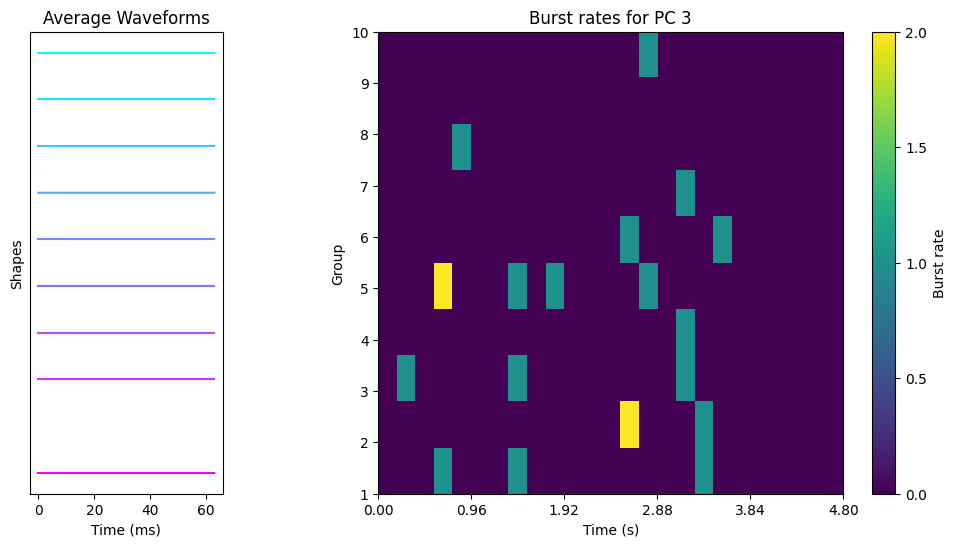

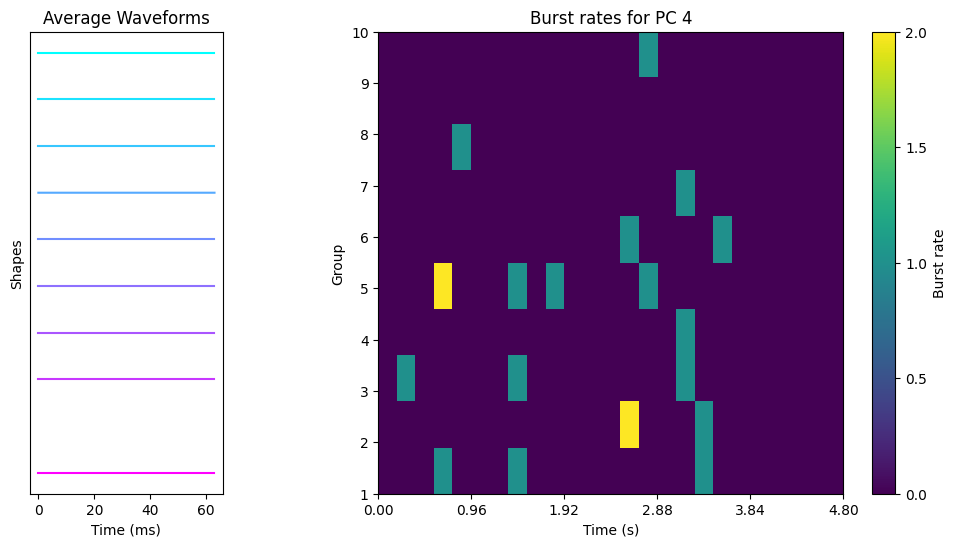

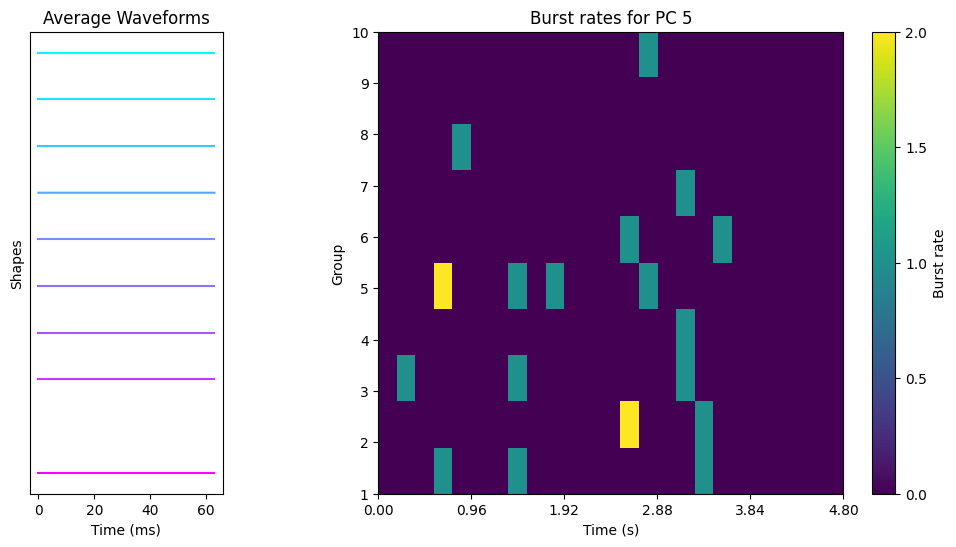

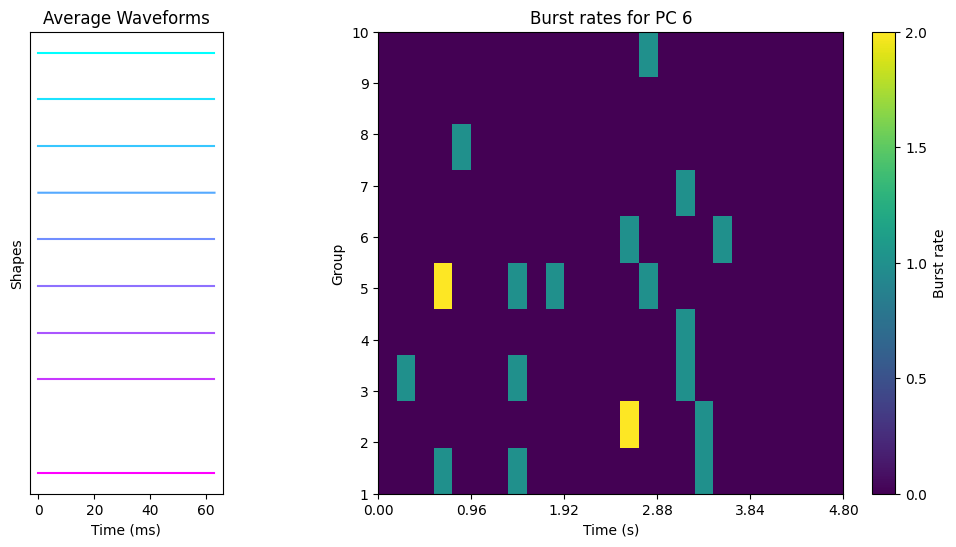

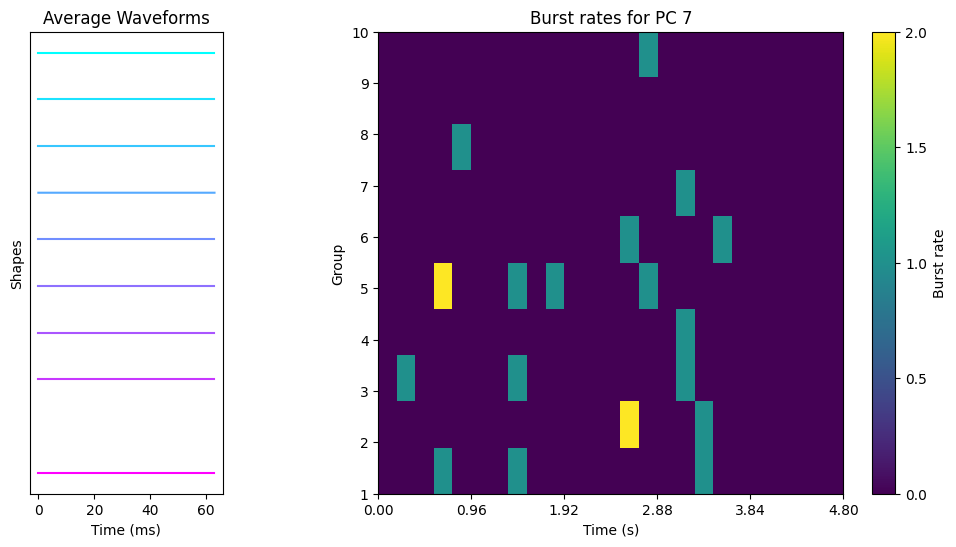

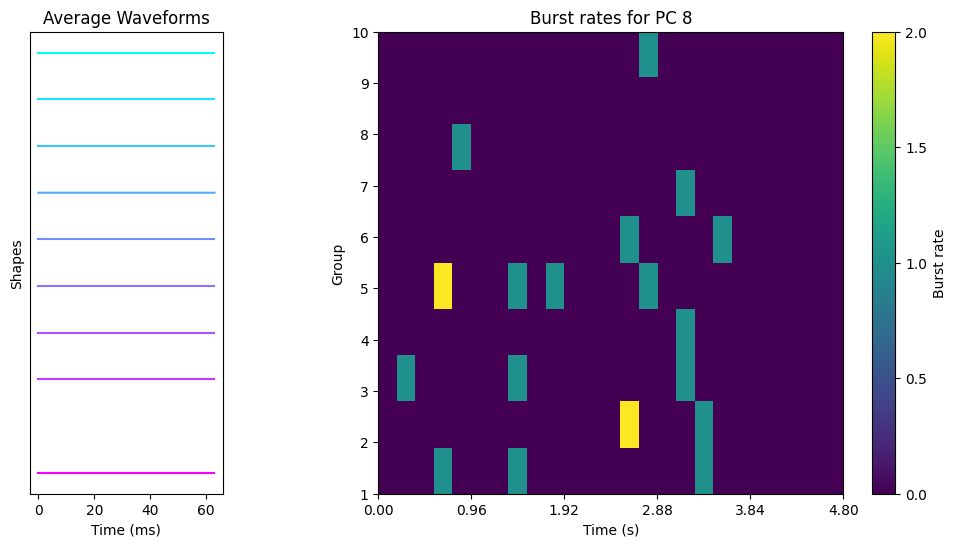

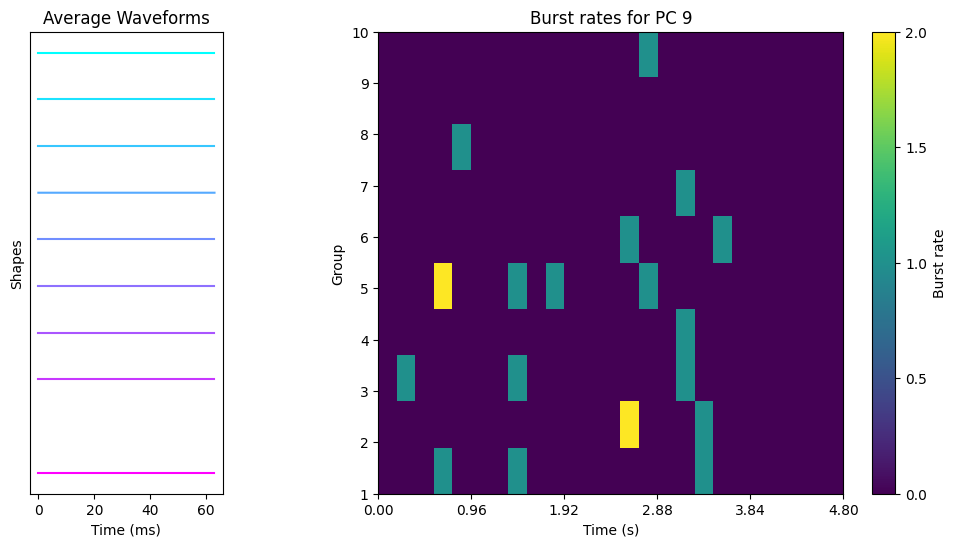

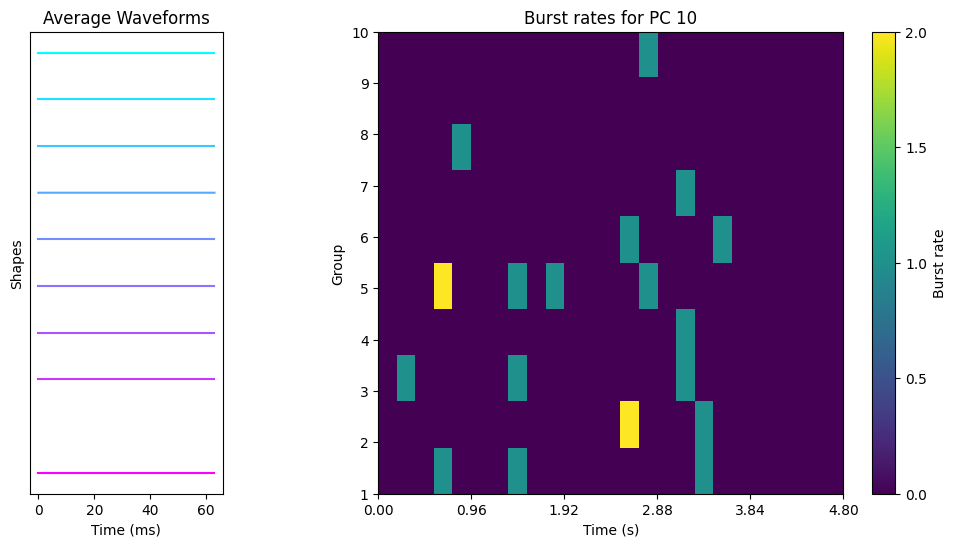

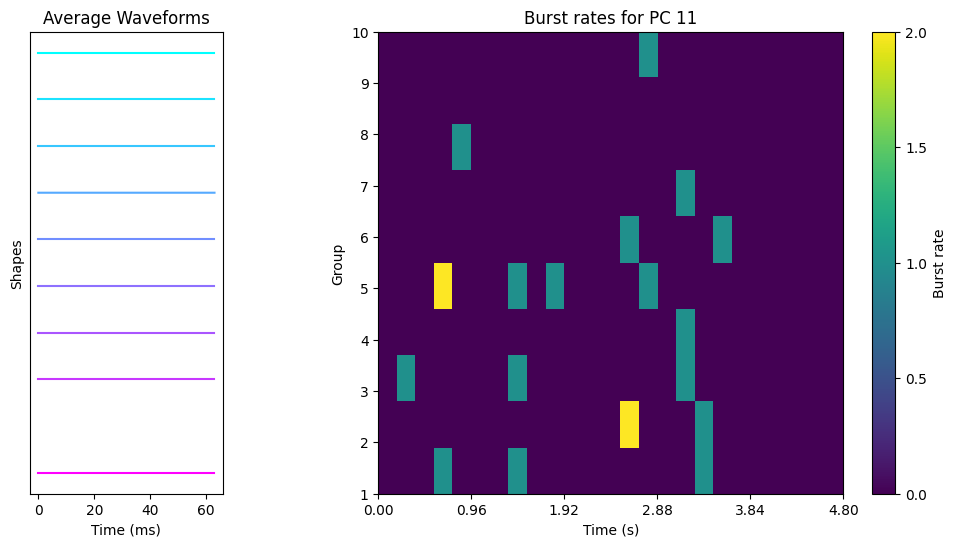

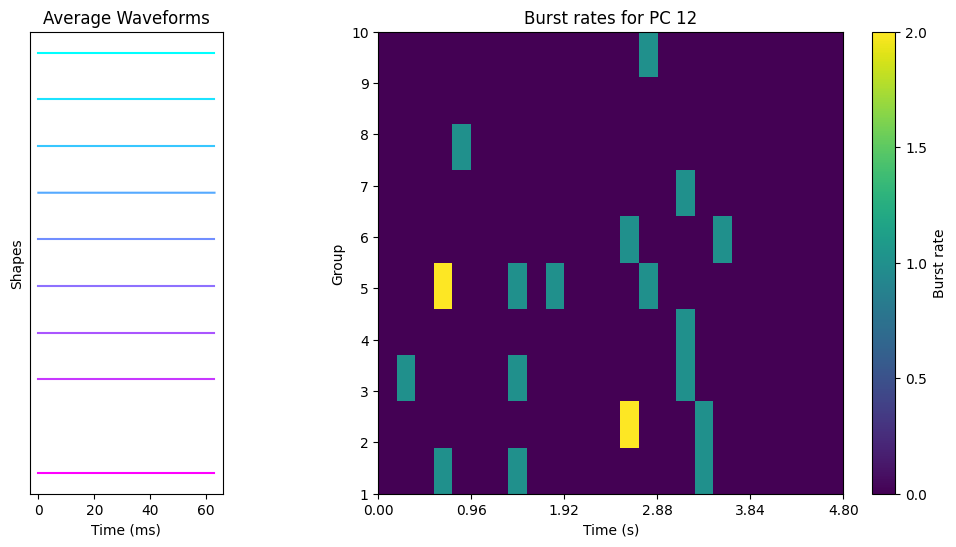

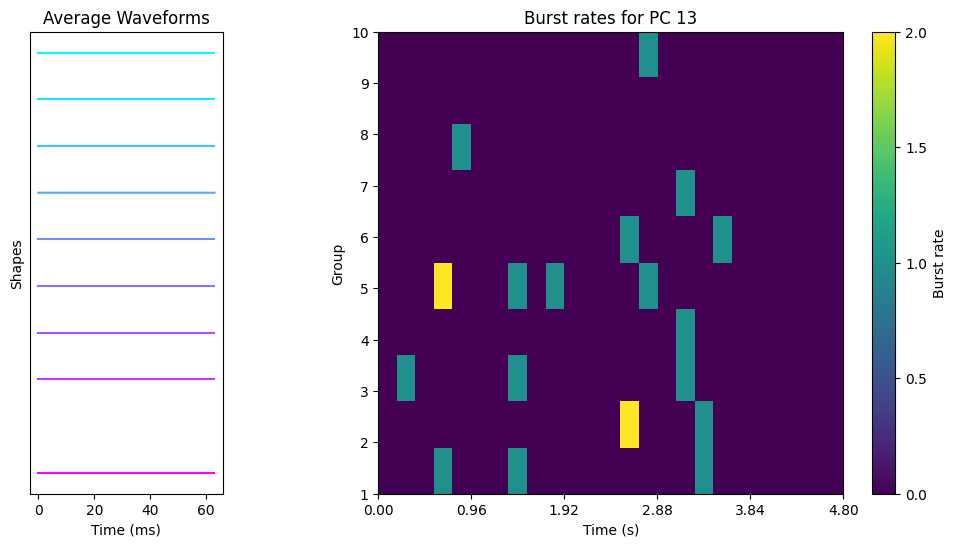

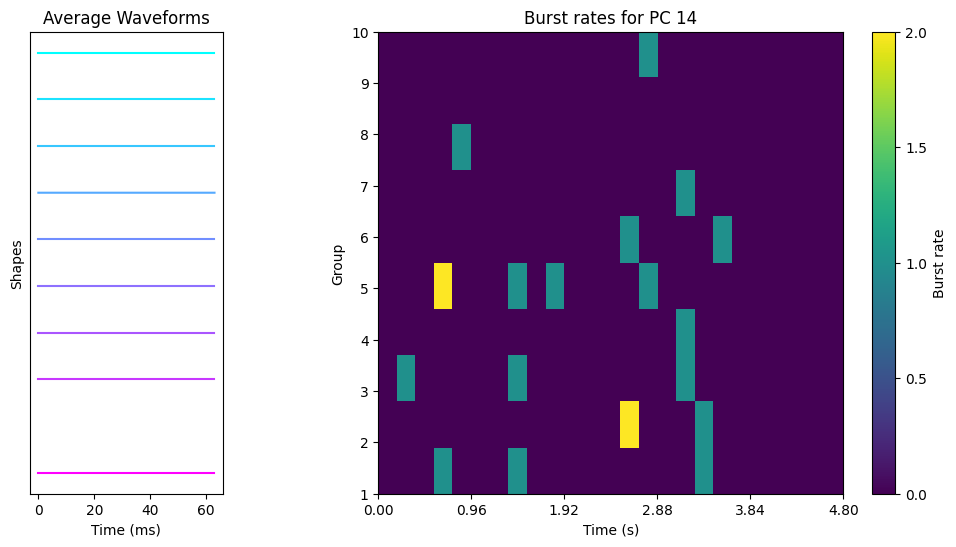

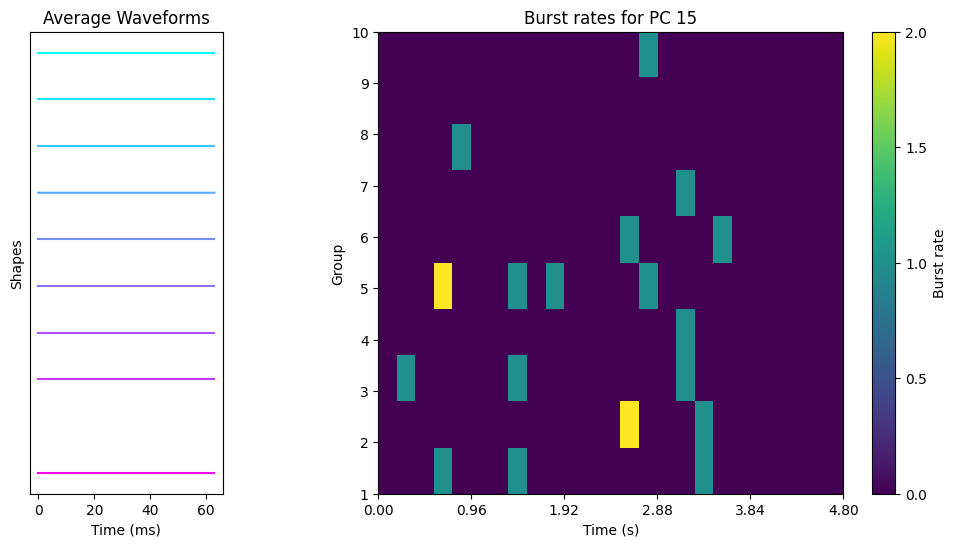

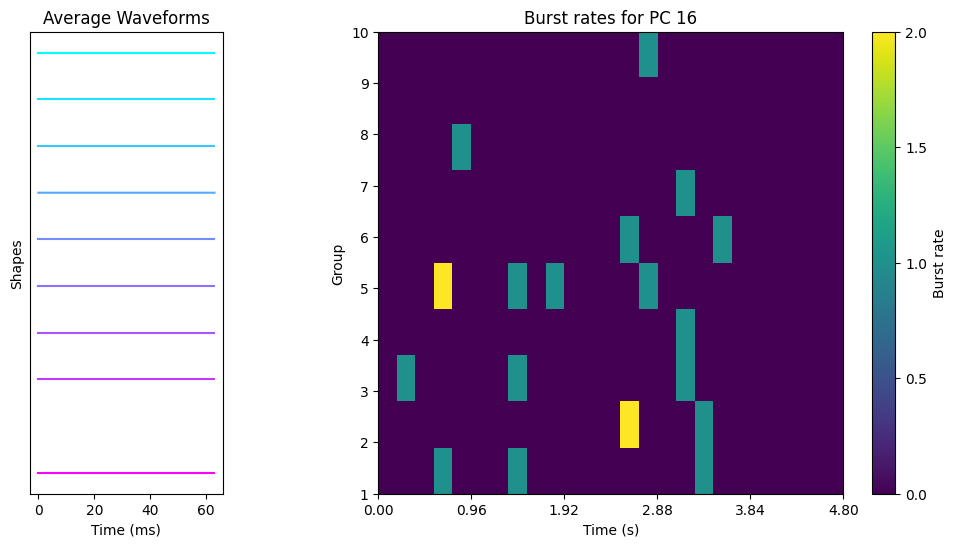

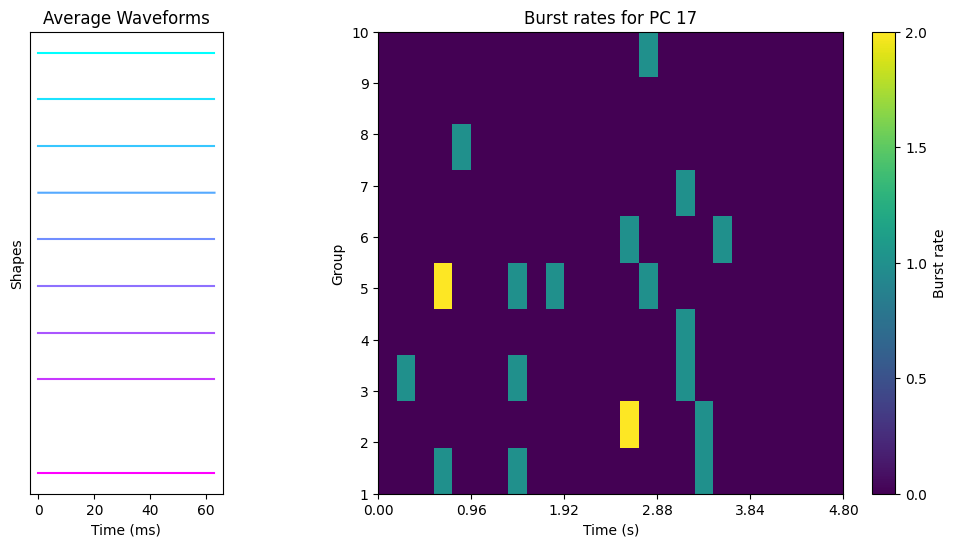

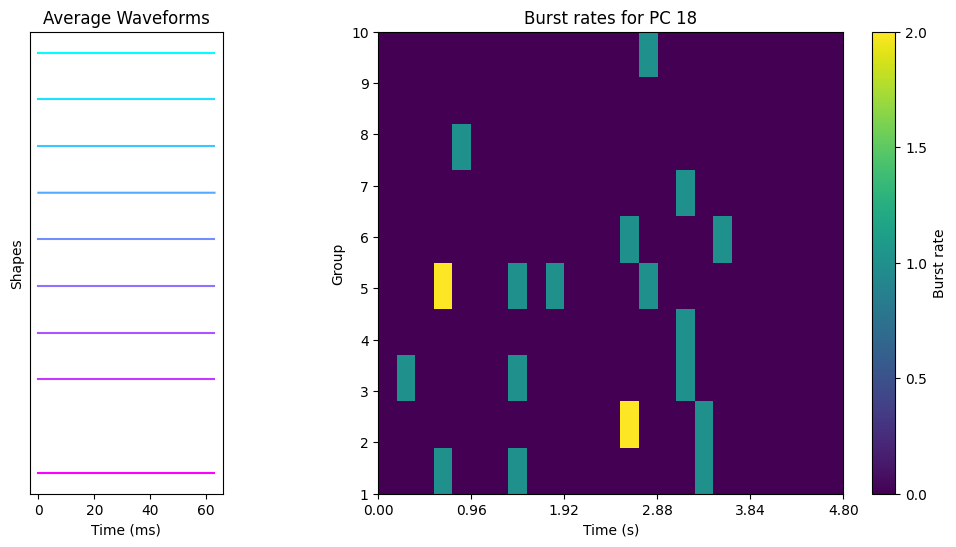

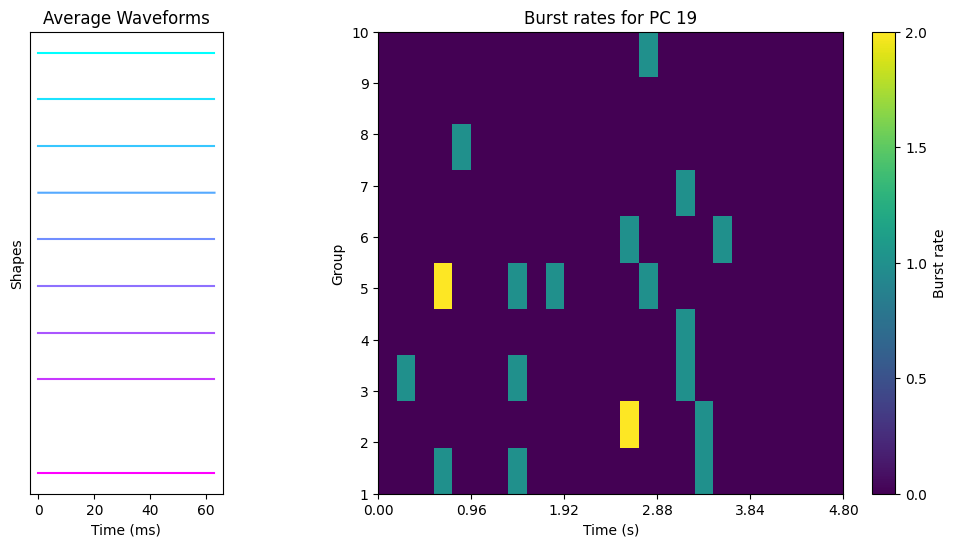

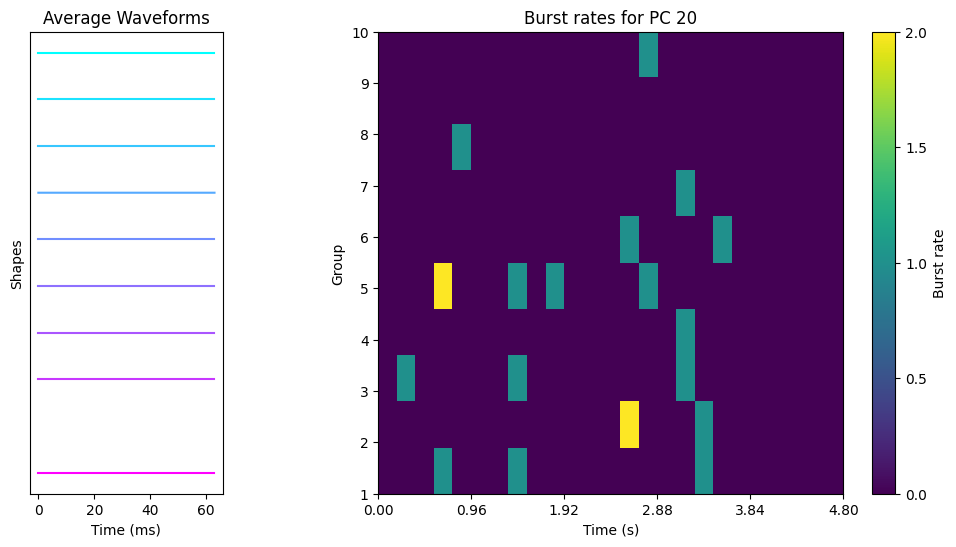

In [12]:
modulation_index, comp_waveforms = bs.waveforms_rate()
bs.plot_burst_rates()